In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold # Para validar

from notebooks.utilidades.graficar import ver_dispersion

from IPython.display import clear_output # Para ver progreso inline

import matplotlib.pyplot as plt

---
# Carga del train

In [57]:
# 12 columnas
cols1 = ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', \
         'centroscomercialescercanos', 'antiguedad', 'habitaciones', \
         'garages', 'banos', 'metroscubiertos', 'metrostotales', 'precio']
train = pd.read_csv('data/train_limpio.csv', usecols=cols1)

train['gimnasio'] = train['gimnasio'].astype(np.uint8)
train['usosmultiples'] = train['usosmultiples'].astype(np.uint8)
train['piscina'] = train['piscina'].astype(np.uint8)
train['escuelascercanas'] = train['escuelascercanas'].astype(np.uint8)
train['centroscomercialescercanos'] = train['centroscomercialescercanos'].astype(np.uint8)

train['antiguedad'] = train['antiguedad'].astype(np.uint8)
train['habitaciones'] = train['habitaciones'].astype(np.uint8)
train['garages'] = train['garages'].astype(np.uint8)
train['banos'] = train['banos'].astype(np.uint8)

train['metroscubiertos'] = train['metroscubiertos'].astype(np.uint16)
train['metrostotales'] = train['metrostotales'].astype(np.uint16)

train['precio'] = train['precio'].astype(np.uint32)

In [58]:
# 1 columna
pob = pd.read_csv('data/features/ftr_poblacion_train.csv')
train['poblacion'] = pob['pob_ciu'].astype(np.uint32)

In [59]:
# 1 columna
idz = pd.read_csv('data/id_zona_V2_train.csv')
train['idzona'] = idz['idzona'].astype(np.uint32)

In [60]:
# 2 columnas
geo = pd.read_csv('data/features/ciudad_prov_lat_lng_V2_train.csv', usecols=['lat', 'lng'])

geo['lat'] = geo['lat'].round(8)
geo['lng'] = geo['lng'].round(8)

train = train.join(geo)

In [61]:
# 32 columnas
provincias = pd.read_csv('data/features/ftr_provincia_ohe_V2_train.csv')
provincias = provincias.astype(np.uint8)

train = train.join(provincias)

In [62]:
# 11 columnas
ciudades = pd.read_csv('data/features/ftr_ciudad_be_V2_train.csv')
ciudades = ciudades.astype(np.uint8)

train = train.join(ciudades)

In [63]:
# 24 columnas
tipodepropiedad = pd.read_csv('data/features/ftr_tipo_prop_ohe_V2_train.csv')
tipodepropiedad = tipodepropiedad.astype(np.uint8)

train = train.join(tipodepropiedad)

In [64]:
# 12 columnas
nul = pd.read_csv('data/features/is_null_train.csv')
# no se usan las direcciones
nul.drop(columns=['direccion_null'], inplace=True)
nul = nul.astype(np.uint8)

train = train.join(nul)

In [65]:
# 2 columnas
dates = pd.read_csv('data/train.csv', usecols=['fecha'], parse_dates=['fecha'])
train['mes'] = dates['fecha'].dt.month.astype(np.uint8)
train['anio'] = dates['fecha'].dt.year.astype(np.uint8)

In [66]:
print('Cantidad de columnas', train.columns.size)
print('Memoria usada', round(train.memory_usage().sum()/(1024*1024), 2), 'MB.')

Cantidad de columnas 97
Memoria usada 27.92 MB.


### División de datos para entrenamiento y objetivo

In [67]:
X = train.drop(columns=['precio'])
y = train['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X_train.shape\t', X_train.shape, '\ty_train.shape\t', y_train.shape)
print('X_test.shape\t', X_test.shape, '\ty_test.shape\t', y_test.shape)

X_train.shape	 (180000, 96) 	y_train.shape	 (180000,)
X_test.shape	 (60000, 96) 	y_test.shape	 (60000,)


---
# Random Forest Regressor
En esta sección solo se prueba con el set de train modificado para entrenar y predecir una sola vez. Más adelante se puede evaluar al predictor a través de un Kfold y según la importancia de sus features.

### Instanciación de predictor (*random_state=42*)

In [21]:
# n_estimators
num_estimadores = 100
# n_jobs
workers = -1
# Instancia para predictor de Random Forest
rfr = RandomForestRegressor(n_estimators=num_estimadores, n_jobs=workers, random_state=42)

### Entrenamiento

In [22]:
%%time
rfr.fit(X_train, y_train)

CPU times: user 11min 56s, sys: 1.5 s, total: 11min 57s
Wall time: 1min 35s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

### Predicción del `y_test`

In [16]:
prediction_t = rfr.predict(X_test)
mean_absolute_error(y_test, prediction_t)

559936.2868199332

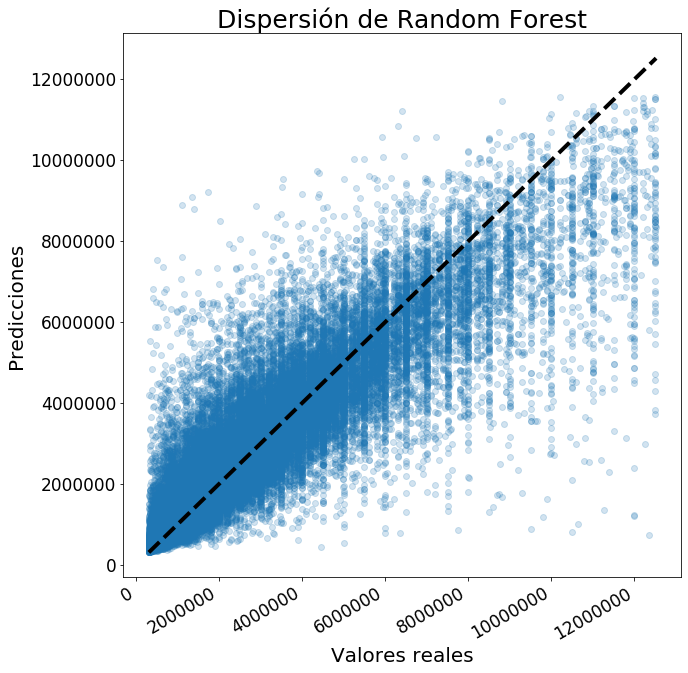

In [16]:
ver_dispersion(y_test, prediction_t, "Random Forest")

---
# Evaluación del predictor
## Con todas las features cargadas

In [77]:
# n_estimators
num_estimadores = 5
# n_jobs
workers = -1
# Instancia para predictor de Random Forest
rfr = RandomForestRegressor(n_estimators=num_estimadores, n_jobs=workers)

# n_splits
splits = 10
# Instancia para KFold
kf = KFold(n_splits=splits)

# Listas para guardar los puntajes y errores de la evaluación
scores = []
errors = []

In [78]:
%%time
i = 1

for train_index, test_index in kf.split(train) :
    clear_output(wait=True)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print('Entrenando fold', i)
    rfr.fit(X_train, y_train)
    prediction_t = rfr.predict(X_test)
    
    scores.append(rfr.score(X_test, y_test))
    errors.append(mean_absolute_error(y_test, prediction_t))
    i = i + 1

Entrenando fold 10
CPU times: user 3min 34s, sys: 44.2 ms, total: 3min 34s
Wall time: 52.6 s


In [79]:
puntajes = np.array(scores)
errores = np.array(errors)

print('Promedio errores', errores.mean().round(0), \
      '\tcon desvío estándar de', errores.std().round(0))
print('Promedio scores\t', puntajes.mean().round(3), \
      '\t\tcon desvío estándar de',puntajes.std().round(3))

Promedio errores 614873.0 	con desvío estándar de 4671.0
Promedio scores	 0.758 		con desvío estándar de 0.004


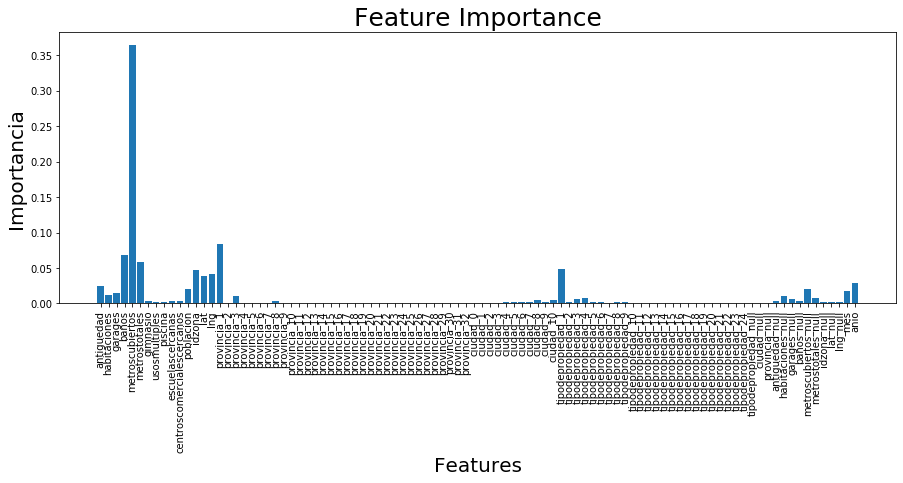

In [17]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns, rfr.feature_importances_)
plt.xlabel('Features', fontsize=20)
plt.xticks(rotation = 90)
plt.ylabel('Importancia', fontsize=20)
plt.title('Feature Importance', fontsize=25)
plt.show()

---
# Selección de features según importancia

De aquí se obtienen las columnas a droppear.

In [25]:
%%time

labels_no_out = [] # lista de labels sin outliers.
importances_no_out = [] # lista de importancias sin outliers.
to_drop = [] # lista de columnas a droppear.
tolerancia = 1e-3
i = 1

indice_vector = np.arange(0, rfr.feature_importances_.size)
for var in indice_vector:
    clear_output(wait=True)
    if (rfr.feature_importances_[var] > tolerancia):
        labels_no_out.append(X_train.columns[var])
        importances_no_out.append(rfr.feature_importances_[var])
    else :
        to_drop.append(X_train.columns[var])
    print(i, 'de', indice_vector.size)
    i = i + 1
    
print('Cantidad de features importantes', len(importances_no_out))
print('Cantidad de features a limpiar', len(to_drop))

96 de 96
Cantidad de features importantes 44
Cantidad de features a limpiar 52
CPU times: user 1min 38s, sys: 1.15 s, total: 1min 39s
Wall time: 20.7 s


In [32]:
to_drop = [
    'provincia_2',
    'provincia_4',
    'provincia_5',
    'provincia_6',
    'provincia_7',
    'provincia_9',
    'provincia_10',
    'provincia_12',
    'provincia_13',
    'provincia_14',
    'provincia_15',
    'provincia_16',
    'provincia_17',
    'provincia_18',
    'provincia_19',
    'provincia_20',
    'provincia_21',
    'provincia_22',
    'provincia_23',
    'provincia_24',
    'provincia_25',
    'provincia_26',
    'provincia_27',
    'provincia_28',
    'provincia_29',
    'provincia_30',
    'provincia_31',
    'provincia_32',
    'ciudad_0',
    'ciudad_1',
    'ciudad_2',
    'ciudad_3',
    'tipodepropiedad_7',
    'tipodepropiedad_10',
    'tipodepropiedad_11',
    'tipodepropiedad_12',
    'tipodepropiedad_13',
    'tipodepropiedad_14',
    'tipodepropiedad_15',
    'tipodepropiedad_16',
    'tipodepropiedad_17',
    'tipodepropiedad_18',
    'tipodepropiedad_19',
    'tipodepropiedad_20',
    'tipodepropiedad_21',
    'tipodepropiedad_22',
    'tipodepropiedad_23',
    'tipodepropiedad_24',
    'tipodepropiedad_null',
    'ciudad_null',
    'provincia_null']

### Se prepara el nuevo set de datos con features importantes

In [80]:
X = train.drop(columns=to_drop)

### División de datos para entrenamiento y objetivo

In [81]:
X = X.drop(columns=['precio'])
y = train['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X_train.shape', X_train.shape, '\ty_train.shape', y_train.shape)
print('X_test.shape', X_test.shape, '\ty_test.shape', y_test.shape)

X_train.shape (180000, 45) 	y_train.shape (180000,)
X_test.shape (60000, 45) 	y_test.shape (60000,)


---
# Evaluación del predictor
## Features filtradas por importancia

In [93]:
# n_estimators
num_estimadores = 5
# n_jobs
workers = -1

kf = KFold(n_splits=10)
# Listas para guardar los puntajes y errores de la evaluación
rfr = RandomForestRegressor(n_estimators=num_estimadores, n_jobs=workers)
scores = []
errors = []

In [94]:
%%time
i = 1

for train_index, test_index in kf.split(train) :
    clear_output(wait=True)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print('Entrenando fold', i)
    rfr.fit(X_train, y_train)
    prediction_t = rfr.predict(X_test)
    
    scores.append(rfr.score(X_test, y_test))
    errors.append(mean_absolute_error(y_test, prediction_t))
    i = i + 1

Entrenando fold 10
CPU times: user 2min 38s, sys: 80.2 ms, total: 2min 39s
Wall time: 39.5 s


In [95]:
puntajes = np.array(scores)
errores = np.array(errors)

print('Promedio errores', errores.mean().round(0), \
      '\tcon desvío estándar de', errores.std().round(0))
print('Promedio scores\t', puntajes.mean().round(3), \
      '\t\tcon desvío estándar de',puntajes.std().round(3))

Promedio errores 616576.0 	con desvío estándar de 3317.0
Promedio scores	 0.758 		con desvío estándar de 0.003


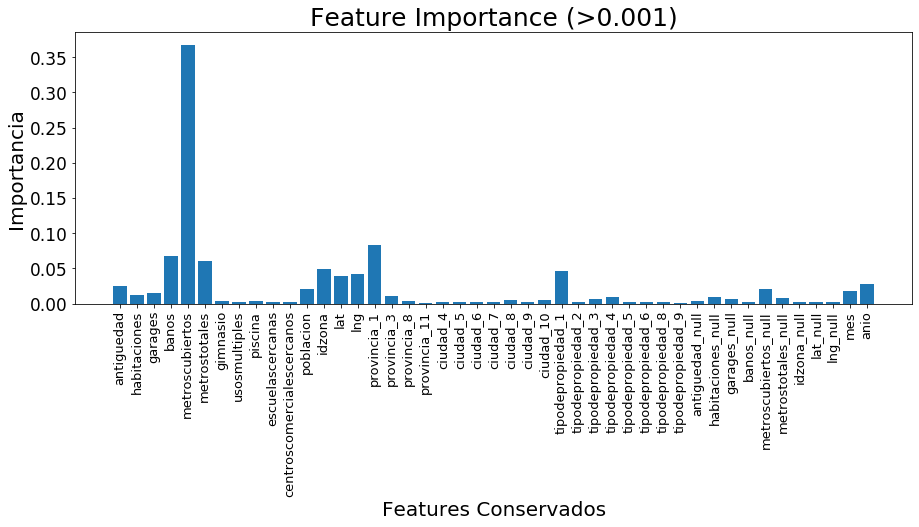

In [96]:
plt.figure(figsize=(15,5))
plt.bar(X_train.columns, rfr.feature_importances_)
plt.xlabel('Features Conservados', fontsize=20)
plt.xticks(rotation = 90, fontsize=13)
plt.ylabel('Importancia', fontsize=20)
plt.yticks(fontsize=17)
plt.title('Feature Importance' + ' (>' + str(tolerancia) + ')', fontsize=25)
plt.show()

# Predicción del test (para submit)

In [36]:
#test = pd.read_csv('data/test_limpio.csv')
#y_pred = rfr.predict(test)

# Generación de submit

In [37]:
#ids = pd.read_csv('data/test.csv', usecols=['id'])

#submit = pd.DataFrame(y_pred, columns=['target'])
#submit.insert(0, 'id', ids)
#submit.to_csv(f"submits/submit_Rand_Forest.csv", index=False)